In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

import ast
import collections
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
import statsmodels.stats as st
import statsmodels.regression.recursive_ls as rls

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

from itertools import combinations
from pandas.plotting import scatter_matrix

import missingno as msno
from collections import Counter

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from director_scrap import director_scrap
from operator import itemgetter

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms import bipartite
from pyvis.network import Network

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#df is simply the data that we have at the end of the section 2.Merging the data
df = pd.read_table('../data/data_usa.tsv')
df.head(1)

,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release
0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0


In [4]:
df.columns

Index(['Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres', 'Movie_rating',
       'Movie_producer', 'Movie_composer', 'Movie_director', 'Movie_writer',
       'Char_name', 'Actor_birth', 'Actor_gender', 'Actor_height',
       'Actor_ethnicity', 'Actor_name', 'Actor_age_release'],
      dtype='object')

In [5]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    
    # Generate a list of x-axis tick marks and labels every 50 degrees
    tick_marks = range(0, max(deg)+1, 70)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels([str(d) for d in tick_marks])
    

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))
    print("Avg. Clustering coefficient: %.4f" %nx.average_clustering(G))
    print("Number of connected components: %d" %nx.number_connected_components(G))
    print("Size of largest component: %d" %len(max(nx.connected_components(G), key=len)))


Graph with 30650 nodes and 643759 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0014
Global clustering coefficient aka Transitivity: 0.1664
Avg. Clustering coefficient: 0.7502
Number of connected components: 48
Size of largest component: 30290


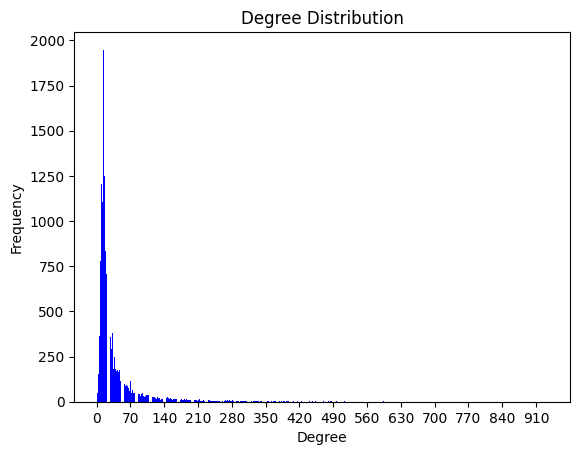

In [6]:
# Create a bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
actors = df['Actor_name'].unique()
movies = df['Movie_name'].unique()

# Add actors and movies as nodes
B.add_nodes_from(actors, bipartite=0)  # Actors
B.add_nodes_from(movies, bipartite=1)  # Movies

# Add edges between actors and movies
df.apply(lambda row: B.add_edge(row['Actor_name'], row['Movie_name']), axis=1)

# Create weighted projected graph
actor_network = nx.Graph()

# Add weighted edges between all pairs of actors
for movie in movies:
    actors_in_movie = [actor for actor in B.neighbors(movie)]
    for i, actor1 in enumerate(actors_in_movie):
        for actor2 in actors_in_movie[i+1:]:
            if actor_network.has_edge(actor1, actor2):
                actor_network[actor1][actor2]['weight'] += 1
            else:
                actor_network.add_edge(actor1, actor2, weight=1)

describe_graph(actor_network)
plot_degree_distribution(actor_network)

In [8]:
from pyvis.network import Network
from tqdm import tqdm

# Initialize the Network, set physics to False for bipartite graph
net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white')

# Add nodes and edges to the PyVis network
for node in tqdm(actor_network.nodes, desc="Adding nodes"):
    net.add_node(node)

for edge in tqdm(actor_network.edges, desc="Adding edges"):
    net.add_edge(edge[0], edge[1], value=actor_network[edge[0]][edge[1]]['weight'])

# Show the network
net.show('actor_network.html')

Adding edges:  16%|█▌        | 100212/643759 [08:30<1:40:06, 90.50it/s]

In [ ]:
# Louvain method
partition = community_louvain.best_partition(actor_network)

# Add community attribute to the nodes
nx.set_node_attributes(actor_network, partition, "louvain")

# Plot it out
pos = nx.spring_layout(actor_network, k=0.2)
plt.figure(figsize=(10, 10))  # Set the figure size

# Draw the edges
nx.draw_networkx_edges(actor_network, pos, alpha=0.2)

# Draw the nodes, colored by community
node_colors = [actor_network.nodes[n]["louvain"] for n in actor_network.nodes]
nx.draw_networkx_nodes(actor_network, pos, node_color=node_colors, node_size=100, cmap=plt.cm.jet)

plt.axis('off')
plt.show()

In [ ]:
# Louvain method
partition = community_louvain.best_partition(actor_network)

# Initialize the Network
net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white')

# Create a color map
color_map = plt.get_cmap('viridis', max(partition.values())+1)

# Add nodes to the network
for node in actor_network.nodes:
    net.add_node(node, 
                 title=node, 
                 color=color_map(partition[node]),
                 size=10)

# Add edges to the network
for edge in actor_network.edges:
    net.add_edge(edge[0], edge[1], value=actor_network[edge[0]][edge[1]]['weight'])

# Show the network
net.show('actor_network.html')